# 1. Imports, Cleaning and EDA

## 1.1. Imports

In [1]:
from pySimFinLIB import pySimFin
import pandas as pd
import seaborn as sns
from simfin.names import *
import matplotlib.pyplot as plt
import requests
from dotenv import load_dotenv
import os
import pandas as pd

import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LinearSegmentedColormap

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.2 Data Cleaning

In [2]:
ticker = 'AAPL'
startDate = '2022-01-01'
endDate = '2023-01-01'

In [3]:
psf = pySimFin()

In [4]:
infoDF = psf.getCompanyInfo(ticker)
companyDF = psf.getCompanyList()
pricesDF = psf.getStockPrices(ticker,startDate,endDate)

KeyboardInterrupt: 

In [ ]:
companyDF

In [ ]:
stock_data = psf.getStockPrices(ticker, startDate, endDate)
stock_data 

In [10]:
def selectMultipleStocks(selected_stocks, startDate, endDate):
    selected_stock_data = {}

    for ticker in selected_stocks:
        # Get stock data for each ticker
        stock_data = psf.getStockPrices(ticker, startDate, endDate)
        stock_data = stock_data['Last Closing Price']
        
        
        # Store stock data in the dictionary with the ticker as the key
        selected_stock_data[ticker] = stock_data

    return pd.DataFrame(selected_stock_data)

In [ ]:


selected_stocks = ['AAPL','AMZN','NFLX','GOOG']

psf.selectMultipleStocks(selected_stocks, startDate, endDate)

In [ ]:
def tickerFind(nameList,companyDF):
    tickerList = []
    for name in nameList:
        for index, company in companyDF.iterrows():
            if name == company['name']:
                tickerList.append(company['ticker'])
    return tickerList

names = list(companyDF['name'].sample(5))

tickerFind(names,companyDF)

# TS Modelling

In [13]:
psf = pySimFin()

In [ ]:
stockPrice = psf.selectSingleStock('AAPL', startDate, endDate)

additive_decomposition = seasonal_decompose(stockPrice, model="additive", period=12)
multiplicative_decomposition = seasonal_decompose(stockPrice, model="multiplicative", period=12)

# Plot both decompositions side by side
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

navy = "#000080"
gold = "#B89336"
green = "#0B6725"
red = "#C00000"

# Additive Decomposition Plots
axes[0, 0].plot(stockPrice.index, stockPrice, color="#000080")
axes[0, 0].set_title("Original Time Series")

axes[1, 0].plot(stockPrice.index, additive_decomposition.trend, color="#B89336")
axes[1, 0].set_title("Additive Trend Component")

axes[2, 0].plot(stockPrice.index, additive_decomposition.seasonal, color="#0B6725")
axes[2, 0].set_title("Additive Seasonal Component")

axes[3, 0].plot(stockPrice.index, additive_decomposition.resid, color="#C00000")
axes[3, 0].set_title("Additive Residual Component")

# Multiplicative Decomposition Plots
axes[0, 1].plot(stockPrice.index, stockPrice, color="#000080")
axes[0, 1].set_title("Original Time Series")

axes[1, 1].plot(stockPrice.index, multiplicative_decomposition.trend, color="#B89336")
axes[1, 1].set_title("Multiplicative Trend Component")

axes[2, 1].plot(stockPrice.index, multiplicative_decomposition.seasonal, color="#0B6725")
axes[2, 1].set_title("Multiplicative Seasonal Component")

axes[3, 1].plot(stockPrice.index, multiplicative_decomposition.resid, color="#C00000")
axes[3, 1].set_title("Multiplicative Residual Component")

plt.tight_layout()
plt.show()

In [15]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def compare_decompositions(ts, model_type='multiplicative'):
    ts = ts.dropna()
    if model_type == 'multiplicative':
        decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative', period=12)
    else:
        decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=12)

    # Get the decomposed components
    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal.dropna()
    residual = decomposition.resid.dropna()

    # Calculate errors between original and fitted series
    fitted_values = trend + seasonal + residual if model_type == 'additive' else trend * seasonal * residual

    # Evaluate performance using MAE and RMSE
    mae = mean_absolute_error(ts, fitted_values)
    rmse = root_mean_squared_error(ts, fitted_values, squared=False)

    return mae, rmse

In [ ]:
stockPrice = psf.selectSingleStock('AAPL', startDate, endDate)

decomposition = sm.tsa.seasonal_decompose(stockPrice, model='multiplicative', period=7)

# Check if any of the components have NaN values
print("Trend NaNs:", decomposition.trend.isna().sum())
print("Seasonal NaNs:", decomposition.seasonal.isna().sum())
print("Residual NaNs:", decomposition.resid.isna().sum())

In [17]:
df = pricesDF.copy()
df = df.reset_index()

In [ ]:
df.head()

In [19]:


# Rename for clarity (optional)
df.rename(columns={
    'Last Closing Price': 'Close',
    'Opening Price': 'Open',
    'Highest Price': 'High',
    'Lowest Price': 'Low',
    'Trading Volume': 'Volume'
}, inplace=True)

# Create next day's closing price as target
df['Next_Close'] = df['Close'].shift(-1)

# Drop rows with missing values (last row will be NaN after shift)
df = df.dropna()

# Convert Date column to datetime (if not already)
df['Date'] = pd.to_datetime(df['Date'])

# Define features and target
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Next_Close']


In [20]:

from sklearn.model_selection import train_test_split

# Use 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Keep time order
)


In [21]:
from sklearn.linear_model import LinearRegression

# Initialize and train model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Test Samples')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    'Linear Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'R²': r2
    }

# Display results
import pandas as pd

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='MAE')  # Lower MAE is better
results_df


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for name, model in models.items():
    y_pred = model.predict(X_test)
    plt.plot(y_pred, label=f'{name} Prediction', alpha=0.7)

plt.plot(y_test.values, label='Actual', linewidth=2, linestyle='--', color='black')
plt.title('Model Predictions vs Actual')
plt.xlabel('Test Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import requests

url = "https://backend.simfin.com/api/v3/companies/statements/compact?ticker=AAPL&statements=PL&period=&start=2022-01-01&end=2023-01-01"

headers = {
    "accept": "application/json",
    "Authorization": "70d5d920-9f9e-4062-9311-1b4df7c98ba4"
}

response = requests.get(url, headers=headers)

print(response.text)

In [ ]:
def statements(ticker,type,startDate,endDate):
    url = f"https://backend.simfin.com/api/v3/companies/statements/compact?ticker={ticker}&statements={type}&period=&start={startDate}&end={endDate}"

    headers = {
        "accept": "application/json",
        "Authorization": "70d5d920-9f9e-4062-9311-1b4df7c98ba4"
    }

    response = requests.get(url, headers=headers)

    print(response.text)

statements('AAPL','PL','2022-01-01','2023-01-01')

In [ ]:
psf = pySimFin()
psf.getStatementsData('AAPL','PL','2022-01-01','2023-01-01')

In [30]:
from pySimFinLIB import pySimFin
psf = pySimFin()
df = psf.statements('AAPL','DERIVED','2018-01-01','2026-01-01')

In [ ]:
tickerList = list(psf.getCompanyList()['ticker'])

masterDF = pd.DataFrame()
for ticker in tickerList:
    df = psf.statements(ticker, 'DERIVED', '2019-01-01', '2020-01-01')

    masterDF = pd.concat([masterDF, df], ignore_index=True)


In [ ]:
df[df['Fiscal Period']=='FY']

In [ ]:
import importlib
import pySimFinLIB
importlib.reload(pySimFinLIB)

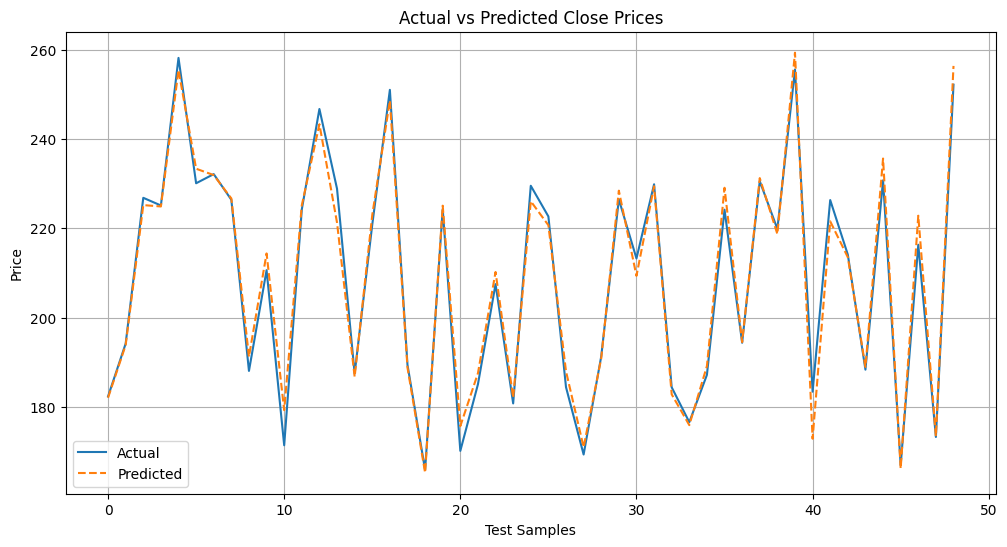

Mean Squared Error (MSE): 11.274181967724545
R² Value: 0.9832127206991332
Root Mean Squared Error (RMSE): 3.3577048660840556
Percentage RMSE: 1.6101105695423816%
Next Day Price Predictions: 252.62166486771022


In [5]:
from pySimFinLIB import pySimFin
psf = pySimFin()

pricesDF = psf.getStockPrices('AAPL','2023-12-01','2025-01-01')

import LinReg2

mse, r2, rmse, percentage_rmse, nextDay = LinReg2.linreg2(pricesDF)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Value: {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percentage RMSE: {percentage_rmse}%")
print(f"Next Day Price Predictions: {nextDay}")

In [8]:
import requests

logo_API_key = 'TOPXVVT0OqevUxpYwXiMPA==d6gb3gYVVrMK6Pne'

name = 'Microsoft'
api_url = f'https://api.api-ninjas.com/v1/logo?ticker={ticker}'
response = requests.get(api_url, headers={'X-Api-Key': logo_API_key})
if response.status_code == requests.codes.ok:
    print(response.text)
else:
    print("Error:", response.status_code, response.text)

[]
